In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
x = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [3]:
x_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Create Combined attributes
## Cabin
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

# Create Transformer for combind attrubtes

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
new_columns = ['TotalSpend', 'AgeBucket', 'Deck', 'Num', 'Side', 'Group', 'RelativeNo']
class CombindedAttrutes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        TotalSpend = X["RoomService"] + X['Spa'] + X['ShoppingMall'] + X['VRDeck'] + X['FoodCourt']
        AgeBucket = X["Age"] // 15 * 15
        split_values = X['Cabin'].str.split('/', expand=True)
        Deck = split_values[0]
        Num = split_values[1]
        Side = split_values[2]
        id_split = X['PassengerId'].str.split('_', expand=True)
        Group = id_split[0]
        group_counts = Group.value_counts()

        # Map the group counts to the corresponding group in each row
        RelativeNo = Group.map(group_counts)
        # Create a DataFrame from the new attributes
        new_attrs = pd.DataFrame({
            'TotalSpend': TotalSpend,
            'AgeBucket': AgeBucket,
            'Deck': Deck,
            'Num': Num,
            'Side': Side,
            'Group': Group,
            'RelativeNo': RelativeNo
        })
        
        # Concatenate the new attributes to the original DataFrame
        return pd.concat([X, new_attrs], axis=1)
        

In [6]:
ca = CombindedAttrutes()
x__ = ca.transform(x)
#x__.head()

In [7]:
x = pd.DataFrame(x__, columns=list(x.columns)+new_columns)
x.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,TotalSpend,AgeBucket,Deck,Num,Side,Group,RelativeNo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0.0,30.0,B,0,P,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,736.0,15.0,F,0,S,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,10383.0,45.0,A,0,S,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,5176.0,30.0,A,0,S,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,1091.0,15.0,F,1,S,0004,1


In [8]:
x['RelativeNo'].value_counts()

RelativeNo
1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: count, dtype: int64

In [9]:
target = x['Transported']
predictors = x.copy()

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

In [11]:
num = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Num', 'TotalSpend']
#num = ['Num', ]

In [12]:
cat = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Deck', 'Side', 'AgeBucket']

- Cabin needs to be decoded


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  #fills missing data
        ("scaler", StandardScaler())
    ])

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")), #fills missing data
        ("cat_encoder", OneHotEncoder(handle_unknown='ignore')),
    ]) 

In [15]:
preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

In [16]:
x_processed = preprocess_pipeline.fit_transform(x_train[num + cat])
x_processed.shape[1]

33

In [17]:
# process 
x_val_processed = preprocess_pipeline.transform(x_val[num + cat]) #fit_transform creates the wrong number
x_val_processed.shape[1]

33

# Fit Models on test Data

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=20,            # Maximum depth of the tree
    max_features='sqrt',     # Number of features to consider when looking for the best split
    min_samples_leaf=4,      # Minimum number of samples required to be at a leaf node
    min_samples_split=10,    # Minimum number of samples required to split an internal node
    random_state=69,         # Seed for random number generator
    n_jobs=12                # Number of jobs to run in parallel
)

In [20]:
forest_clf.fit(x_processed, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_jobs=12, random_state=69)

In [21]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, x_processed, y_train, cv=10)
forest_scores.mean()

#.78879

0.8007374631268437

In [22]:
print("Training Score for ForestModel is: ", (forest_clf.score(x_processed, y_train)*100), '%')
print("Validation Accuracy: ", accuracy_score(y_val, forest_clf.predict(x_val_processed))) 

Training Score for ForestModel is:  87.09439528023599 %
Validation Accuracy:  0.8081547307893361


# Lets try Random Forest Regressor
0.435 best score

# LogisticRegression

In [23]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(C=0.5,penalty='l1',solver='liblinear')
model1.fit(x_processed,y_train)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

In [24]:
model1_scores = cross_val_score(model1, x_processed, y_train, cv=10)
model1_scores.mean()

0.7907079646017698

In [25]:
#printing the training score
print('The training score for logistic regression is:',(model1.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, model1.predict(x_val_processed))) #79.24 #79.76 (7) #79.19 (15)

The training score for logistic regression is: 79.35103244837758 %
Validation accuracy 0.7909043387349712


# Gradient Boosting Classifier

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
model3 = GradientBoostingClassifier(n_estimators=24,learning_rate=1.2)
model3.fit(x_processed,y_train)

GradientBoostingClassifier(learning_rate=1.2, n_estimators=24)

In [27]:
model3_scores = cross_val_score(model3, x_processed, y_train, cv=10)
model3_scores.mean()

0.786283185840708

In [28]:
#printing the training score
print('The training score for logistic regression is:',(model3.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, model3.predict(x_val_processed))) #80.29 #79.17 (7) #79.92(15)

The training score for logistic regression is: 83.3038348082596 %
Validation accuracy 0.7914270778881338


# SVC

In [29]:
from sklearn.svm import SVC

In [30]:
svm_clf = SVC(C=10, gamma='scale', kernel='rbf')
svm_scores = cross_val_score(svm_clf, x_processed, y_train, cv=10)
svm_scores.mean()

0.8047197640117993

In [31]:
svm_clf.fit(x_processed, y_train)

SVC(C=10)

In [32]:
#printing the training score
print('The training score for logistic regression is:',(svm_clf.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, svm_clf.predict(x_val_processed))) #79.508 #79.87 (7) #79.87

The training score for logistic regression is: 83.65781710914455 %
Validation accuracy 0.8044955567171981


# Grid Search

In [33]:
x_processed[0]

array([-0.1246274 , -0.25261197, -0.27740787,  0.37821755, -0.18428617,
       -0.24304541, -0.15271548,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from scipy.stats import expon, reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [35]:
'''param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }
#svm_reg = SVR()
#rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42, n_jobs=-1)
rnd_search.fit(x_processed, y_train)
'''

"param_distribs = {\n        'kernel': ['linear', 'rbf'],\n        'C': reciprocal(20, 200000),\n        'gamma': expon(scale=1.0),\n    }\n#svm_reg = SVR()\n#rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,\n                                n_iter=50, cv=5, scoring='neg_mean_squared_error',\n                                verbose=2, random_state=42, n_jobs=-1)\nrnd_search.fit(x_processed, y_train)\n"

In [36]:
'''


svm_reg_scores = cross_val_score(svm_reg, x_processed, y_train, cv=10)
svm_reg_scores.mean()
'''

'\n\n\nsvm_reg_scores = cross_val_score(svm_reg, x_processed, y_train, cv=10)\nsvm_reg_scores.mean()\n'

In [37]:
'''
print('The training score for logistic regression is:',(svm_clf.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, svm_clf.predict(x_val_processed))) #79.508 #79.87 (7) #79.87
'''

"\nprint('The training score for logistic regression is:',(svm_clf.score(x_processed,y_train)*100),'%')\nprint('Validation accuracy', accuracy_score(y_val, svm_clf.predict(x_val_processed))) #79.508 #79.87 (7) #79.87\n"

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
knn_clf = KNeighborsClassifier(n_neighbors=25, p=2, weights='uniform')

knn_clf.fit(x_processed, y_train)

KNeighborsClassifier(n_neighbors=25)

In [40]:
knn_scores = cross_val_score(knn_clf, x_processed, y_train, cv=10)
knn_scores.mean()

0.7929203539823009

In [41]:
print('The training score for logistic regression is:',(knn_clf.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, knn_clf.predict(x_val_processed))) #79.508 #79.87 (7) #79.87

The training score for logistic regression is: 80.61946902654867 %
Validation accuracy 0.7877679038159958


In [42]:
from sklearn.naive_bayes import GaussianNB

In [43]:
gnb = GaussianNB()

In [44]:
gnb.fit(x_processed, y_train)

GaussianNB()

In [45]:
gnb_scores = cross_val_score(gnb, x_processed, y_train, cv=10)
gnb_scores.mean()

0.7123893805309736

In [46]:
print('The training score for logistic regression is:',(gnb.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, gnb.predict(x_val_processed))) #79.508 #79.87 (7) #79.87

The training score for logistic regression is: 72.30088495575221 %
Validation accuracy 0.7051751176163095


In [47]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.naive_bayes import MultinomialNB

# # Define the parameter grid
# param_grid = {
#     'alpha': [0.01, 0.1, 1, 10, 100]  # Smoothing parameter
# }

# Create the GridSearchCV object
#grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', verbose=2)

# Assuming you have a dataset with features X and labels y
# Fit the grid search to the data
#grid_search.fit(x_processed, y_train)

# XGBoost

In [48]:
import xgboost as xgb

In [49]:
xgb_model = xgb.XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    n_estimators=200,
    reg_alpha=0.1,
    reg_lambda=100,
    subsample=0.6
)
xgb_model.fit(x_processed,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [50]:
xgb_model_scores = cross_val_score(xgb_model, x_processed, y_train, cv=10)
xgb_model_scores.mean()

0.806047197640118

In [51]:
print('The training score for logistic regression is:',(xgb_model.score(x_processed,y_train)*100),'%')
print('Validation accuracy', accuracy_score(y_val, xgb_model.predict(x_val_processed))) #79.508 #79.87 (7) #79.87

The training score for logistic regression is: 83.28908554572271 %
Validation accuracy 0.8065865133298484


# CAT BOOST**

In [52]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [54]:
#Convert y to bool
y_cat = x_train['Transported']
y_cat.info()

<class 'pandas.core.series.Series'>
Index: 6780 entries, 6709 to 2732
Series name: Transported
Non-Null Count  Dtype
--------------  -----
6780 non-null   bool 
dtypes: bool(1)
memory usage: 59.6 KB


In [55]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(x_processed, y_cat)

In [56]:
# cat_model_scores = cross_val_score(cat_model, x_processed, y_pred_bool, cv=10)
# cat_model_scores.mean()

In [57]:
# print('The training score for logistic regression is:',(cat_model.score(x_processed,y_train)*100),'%')
# print('Validation accuracy', accuracy_score(y_val, cat_model.predict(x_val_processed))) #79.508 #79.87 (7) #79.87

# Grid Search for SVM

# Compare methods

In [58]:
scores = [forest_scores, model1_scores, model3_scores, svm_scores, knn_scores, gnb_scores, xgb_model_scores]
names = ['Random Forest', 'Logistic Regression', 'Gradent Boosting', 'SVM', 'Knn', 'GNB', 'XGB']

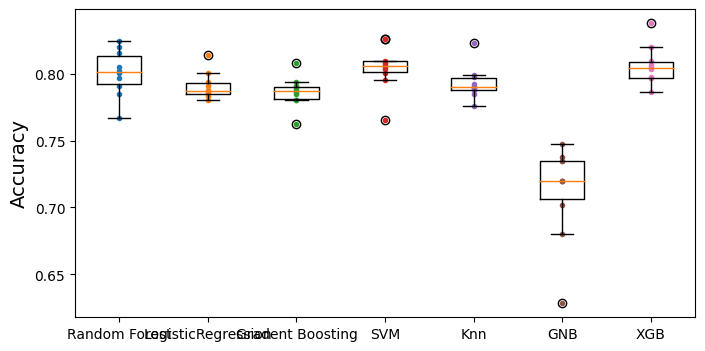

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.plot([1]*10, forest_scores, ".")
plt.plot([2]*10, model1_scores, ".")
plt.plot([3]*10, model3_scores, ".")
plt.plot([4]*10, svm_scores, ".")
plt.plot([5]*10, knn_scores, ".")
plt.plot([6]*10, gnb_scores, ".")
plt.plot([7]*10, xgb_model_scores, ".")
plt.boxplot(scores, labels=("Random Forest", "LogisticRegression", 'Gradent Boosting', 'SVM', 'Knn', 'GNB', 'XGB'))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [60]:
results = pd.DataFrame()

In [61]:
mean_scores = {}

In [62]:
for name, score_array in zip(names, scores):
    mean_scores[name] = round(sum(score_array) / len(score_array) * 100, 2)

In [63]:
df = pd.DataFrame(list(mean_scores.items()), columns=['Model', 'Mean Score'])
df_sorted = df.sort_values(by='Mean Score', ascending=False)
df_sorted

,Model,Mean Score
6,XGB,80.60
3,SVM,80.47
0,Random Forest,80.07
4,Knn,79.29
1,Logistic Regression,79.07
2,Gradent Boosting,78.63
5,GNB,71.24


3	SVM	80.47
0	Random Forest	80.07
1	Logistic Regression	79.01
2	Gradent Boosting	78.64
added new Category

# Retrain on full data

In [64]:
y = x['Transported']

In [65]:
X_ = preprocess_pipeline.transform(x[num + cat])

In [66]:
X_[0]

array([-0.33459854, -0.28308719, -0.27740787, -0.27306231, -0.26153327,
       -1.17478746, -0.53074662,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [67]:
svm_clf.fit(X_, y) #replace model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [68]:
x.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,TotalSpend,AgeBucket,Deck,Num,Side,Group,RelativeNo
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0.0,30.0,B,0,P,0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,736.0,15.0,F,0,S,0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,10383.0,45.0,A,0,S,0003,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,5176.0,30.0,A,0,S,0003,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,1091.0,15.0,F,1,S,0004,1


### GS with age buckets
3	SVM	80.52
0	Random Forest	80.49
1	Logistic Regression	78.97
2	Gradent Boosting	78.91


SVM	80.10
1	Logistic Regression	78.97
2	Gradent Boosting	78.92
0	Random Forest	78.88

# Prepare the Sample Data

In [69]:
sample_raw = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [70]:
#sample["AgeBucket"] = sample["Age"] // 7 * 15
#sample[["AgeBucket", "Transported"]].groupby(['AgeBucket']).mean()

In [71]:
sample_ = ca.transform(sample_raw)
sample = pd.DataFrame(sample_, columns=list(sample_raw.columns)+new_columns)
sample.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,TotalSpend,AgeBucket,Deck,Num,Side,Group,RelativeNo
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0.0,15.0,G,3,S,0013,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,2832.0,15.0,F,4,S,0018,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0.0,30.0,C,0,S,0019,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,7418.0,30.0,C,1,S,0021,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,645.0,15.0,F,5,S,0023,1


In [72]:
#sample["TotalSpend"] = (sample["RoomService"] + sample['Spa'] + sample['ShoppingMall'] + sample['VRDeck'] + sample['FoodCourt'] )

In [73]:
#sample[['Deck', 'Num', 'Side']] = sample['Cabin'].str.split('/', expand=True)

In [74]:
#side_sample = sample['Side'].mode()[0]
#sample['Side'] = sample['Side'].fillna(side_sample)
#sample['Side'] = sample['Side'].map(side_mapping)

In [75]:
x_test = preprocess_pipeline.transform(sample[num + cat])

In [76]:
y_pred = svm_clf.predict(x_test)

In [77]:
result = sample[['PassengerId']].copy()
result['Transported'] = y_pred

In [78]:
result['Transported'] = result['Transported'].astype(bool)

In [79]:
result.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,True
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [80]:
result.to_csv('submission.csv', index=False)

# C